In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!ls /content/drive/MyDrive/finPJ/dataset_419_grey_hist/train | wc -l
!ls /content/drive/MyDrive/finPJ/dataset_419_grey_hist/test | wc -l

520
350


In [ ]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/finPJ/dataset/')

In [ ]:
# train 이미지 전처리
import glob
files_joined = os.path.join('/content/drive/MyDrive/finPJ/dataset/train', "*.jpg")
list_files = glob.glob(files_joined)
print(len(list_files))

os.chdir('/content/drive/MyDrive/finPJ/dataset/')
%mkdir train_pretreated
%cd train_pretreated
os.getcwd()

520
/content/drive/MyDrive/finPJ/dataset/train_pretreated


'/content/drive/MyDrive/finPJ/dataset/train_pretreated'

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm 

for idx, my_image in enumerate(list_files):
  print(my_image)
  image = cv2.imread(my_image)
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  ## CLACHE 추가
  clahe = cv2.createCLAHE(clipLimit=15, tileGridSize=(7, 7))
  cl1 = clahe.apply(image_gray) 

  cv2.imwrite('{}'.format(list_files[idx][-8:]), cl1)
  #imS = cv2.resize(cl1, (384, 307))             
  #cv2_imshow(imS)
print('>>> ... train 이미지 전처리 완료') 

In [ ]:
# test 이미지 전처리
import glob
files_joined = os.path.join('/content/drive/MyDrive/finPJ/dataset/test', "*.jpg")
list_files = glob.glob(files_joined)
print(len(list_files))

os.chdir('/content/drive/MyDrive/finPJ/dataset/')
%mkdir test_pretreated
%cd test_pretreated
os.getcwd()

350
/content/drive/MyDrive/finPJ/dataset/test_pretreated


'/content/drive/MyDrive/finPJ/dataset/test_pretreated'

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm 

for idx, my_image in tqdm(enumerate(list_files)):
  image = cv2.imread(my_image)
  #resize_img = cv2.resize(image, (419, 419))
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  ## CLACHE 추가
  clahe = cv2.createCLAHE(clipLimit=15, tileGridSize=(7, 7))
  cl1 = clahe.apply(image_gray) 

  cv2.imwrite('{}'.format(list_files[idx][-8:]), cl1)
print('>>> ... test 이미지 전처리 완료') 

350it [00:19, 17.51it/s]

>>> ... test 이미지 전처리 완료


In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
import os
os.chdir('/content/drive/MyDrive/finPJ/dataset')
os.getcwd()

register_coco_instances("br_chem_data", {}, "label(polygon)_train.json", "train_pretreated")
register_coco_instances("br_chem_data_val", {}, "label(polygon)_train.json", "train_pretreated")
register_coco_instances("br_chem_data_test", {}, "label_test.json", "test_pretreated")

br_chem_data_metadata = MetadataCatalog.get("br_chem_data")
dataset_dicts = DatasetCatalog.get("br_chem_data")

[07/24 06:09:32 d2.data.datasets.coco]: Loaded 520 images in COCO format from label(polygon)_train.json


In [ ]:
br_chem_data_metadata

In [ ]:
os.chdir('/content/drive/MyDrive/finPJ/dataset')

In [ ]:
import json

with open("/content/drive/MyDrive/finPJ/dataset/label_test.json") as f:
  data_test = json.load(f)

data_test['categories'] = [{'id': 1, 'name': 'Normal'}]

print(data_test.keys())

with open('/content/drive/MyDrive/finPJ/dataset/label_test.json', 'w') as f:
    json.dump(data_test, f)

dict_keys(['images', 'categories'])


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("br_chem_data",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 20000
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 180  

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 1 class (Normal)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/24 06:11:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[07/24 06:11:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/24 06:11:38 d2.utils.events]:  eta: 3:53:23  iter: 19  total_loss: 2.692  loss_cls: 0.6326  loss_box_reg: 0.5774  loss_mask: 0.689  loss_rpn_cls: 0.5125  loss_rpn_loc: 0.3419  time: 0.6996  data_time: 0.1203  lr: 0.00019981  max_mem: 6612M
[07/24 06:11:52 d2.utils.events]:  eta: 3:52:29  iter: 39  total_loss: 2.45  loss_cls: 0.5366  loss_box_reg: 0.6093  loss_mask: 0.6007  loss_rpn_cls: 0.3618  loss_rpn_loc: 0.3162  time: 0.6978  data_time: 0.1049  lr: 0.00039961  max_mem: 6612M
[07/24 06:12:06 d2.utils.events]:  eta: 3:51:14  iter: 59  total_loss: 2.199  loss_cls: 0.5059  loss_box_reg: 0.6626  loss_mask: 0.4739  loss_rpn_cls: 0.2841  loss_rpn_loc: 0.2963  time: 0.6951  data_time: 0.1051  lr: 0.00059941  max_mem: 6612M
[07/24 06:12:20 d2.utils.events]:  eta: 3:52:18  iter: 79  total_loss: 2.015  loss_cls: 0.4742  loss_box_reg: 0.6757  loss_mask: 0.3813  loss_rpn_cls: 0.2392  loss_rpn_loc: 0.2598  time: 0.6982  data_time: 0.1091  lr: 0.00079921  max_mem: 6612M
[07/24 06:12:34 d2.uti

In [ ]:
os.chdir('/content/drive/MyDrive/finPJ/dataset')
os.getcwd()

'/content/drive/MyDrive/finPJ/dataset'

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01  
cfg.DATASETS.TEST = ("br_chem_data_val", )
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("br_chem_data_val", cfg, False, output_dir="./output_val/")
val_loader = build_detection_test_loader(cfg, "br_chem_data_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[07/24 10:04:05 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

OrderedDict([('bbox',
              {'AP': 79.62953095437038,
               'AP50': 97.02271381776494,
               'AP75': 94.64363647025694,
               'APl': 90.99341886665057,
               'APm': 80.90447950469243,
               'APs': 67.49268943441436}),
             ('segm',
              {'AP': 69.28349822345882,
               'AP50': 97.00866298021906,
               'AP75': 87.12319699220973,
               'APl': 81.54177886597391,
               'APm': 70.61656063248162,
               'APs': 56.533161225559944})])

In [ ]:
cfg.OUTPUT_DIR

'./output'

In [ ]:
os.getcwd()

'/content/drive/MyDrive/finPJ/dataset'

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("br_chem_data_test", )
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("br_chem_data_test")

evaluator = COCOEvaluator("br_chem_data_test", cfg, False, output_dir="./output_test/")
val_loader = build_detection_test_loader(cfg, "br_chem_data_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[07/24 10:08:25 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

OrderedDict()

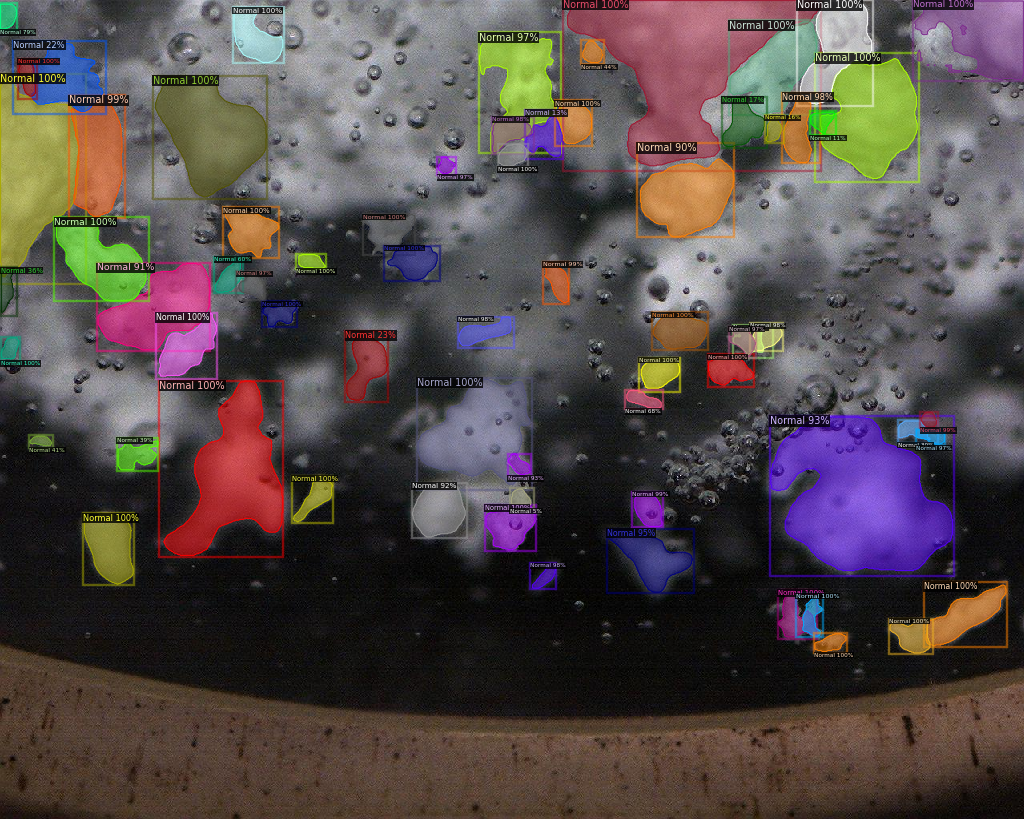

In [ ]:
import glob
from detectron2.utils.visualizer import ColorMode

#imageName = glob.glob('/content/drive/MyDrive/finPJ/dataset/test_pretreated/*jpg')
#im = cv2.imread(imageName[2])
im = cv2.imread('/content/drive/MyDrive/finPJ/dataset/train/0828.jpg')
#print(imageName)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
              metadata=test_metadata,
              scale=0.8
               )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
import random 
d = random.sample(dataset_dicts, 1)[0]
print(d["file_name"])

train_pretreated/0828.jpg


In [ ]:
img = cv2.imread('/content/drive/MyDrive/finPJ/dataset/train/0828.jpg')
visualizer = Visualizer(img[:, :, ::-1], metadata=br_chem_data_metadata, scale=0.9)
vis = visualizer.draw_dataset_dict(d)
cv2_imshow(vis.get_image()[:, :, ::-1])